In [13]:
import numpy as np
import pandas as pd
from TotalMechanicalVolumeOfHUD import TotalMechanicalVolumeOfHUD as tmv
from SurplusValue import surplus_value as sv
from vwfo import Scenario, Platform, Technology, Design, calculate_tradespace_designs
from plotting import plot_figure_SV_V, plot_violinplot

In [4]:
# streamlit select number
num_samples = 100


scenarios = [
    Scenario(id=1, description="Scenario 1", s_x1=["Technology 1", "Technology 2"],                 s_x2=[2022, 2024], s_x3=100),
    Scenario(id=2, description="Scenario 2", s_x1=["Technology 1", "Technology 2"],                 s_x2=[2024, 2026], s_x3=80),
    Scenario(id=3, description="Scenario 3", s_x1=["Technology 1", "Technology 2", "Technology 3"], s_x2=[2026, 2030], s_x3=80)
]

platforms = [
    Platform(id=1, p_x1=300, p_x2=250, p_x3=200),
    Platform(id=2, p_x1=400, p_x2=400, p_x3=300),
    Platform(id=3, p_x1=350, p_x2=350, p_x3=250)
]

technologies = [Technology(id=1, name='Technology 1', volume_coeficients=[1, 3, 1],  factors={'t_x1':[5,10],  't_x2':[2,4],  't_x3':[1000,5000]}),
                Technology(id=2, name='Technology 2', volume_coeficients=[1, 3, 2],  factors={'t_x1':[7,15],  't_x2':[3,7],  't_x3':[5000,20000]}),
                Technology(id=3, name='Technology 3', volume_coeficients=[1, 3, .5], factors={'t_x1':[10,20], 't_x2':[4,10], 't_x3':[1000,30000]})
                ]



In [5]:
designs = []
for i, scenario in enumerate(scenarios):
    designs.append([])
    designs_scenario = []
    for j, platform in enumerate(platforms):
        designs_scenario.append([])
        designs_platform = []
        for k, technology in enumerate(technologies):
            if technology.name in scenario.s_x1:
                print(f"Scenario {i+1} Platform {j+1} Technology {k+1}")
                #designs_scenario.append([i,j,k])
                designs_platform += calculate_tradespace_designs(technology.factors, num_samples, scenario, platform, technology.id)
        designs_scenario[j] = designs_platform

    designs[i] = designs_scenario

Scenario 1 Platform 1 Technology 1
Scenario 1 Platform 1 Technology 2
Scenario 1 Platform 2 Technology 1
Scenario 1 Platform 2 Technology 2
Scenario 1 Platform 3 Technology 1
Scenario 1 Platform 3 Technology 2
Scenario 2 Platform 1 Technology 1
Scenario 2 Platform 1 Technology 2
Scenario 2 Platform 2 Technology 1
Scenario 2 Platform 2 Technology 2
Scenario 2 Platform 3 Technology 1
Scenario 2 Platform 3 Technology 2
Scenario 3 Platform 1 Technology 1
Scenario 3 Platform 1 Technology 2
Scenario 3 Platform 1 Technology 3
Scenario 3 Platform 2 Technology 1
Scenario 3 Platform 2 Technology 2
Scenario 3 Platform 2 Technology 3
Scenario 3 Platform 3 Technology 1
Scenario 3 Platform 3 Technology 2
Scenario 3 Platform 3 Technology 3


In [6]:
columns = ['scenario', 'platform', 'technology', 'platform_compatible', 'volume', 'value', 't_x1', 't_x2', 't_x3', 'x', 'y', 'z']

designs_list = []

for scenario in [0,1,2]:
    for platform in [0,1,2]:
        for design in designs[scenario][platform]:
            designs_list.append([design.scenario.id, 
                                design.platform.id, 
                                design.technology, 
                                design.platform_compatible, 
                                design.volume, 
                                -design.value, 
                                design.t_x1, 
                                design.t_x2, 
                                design.t_x3, 
                                design.x, 
                                design.y, 
                                design.z])

df = pd.DataFrame(designs_list, columns=columns)

In [7]:
s1 = df[df['scenario'] == 1]
s2 = df[df['scenario'] == 2].reset_index()
s3 = df[df['scenario'] == 3].reset_index()
s23 = df[(df['scenario'] == 2) | (df['scenario'] == 3)].reset_index()

In [8]:
puntos4 = [[],[],[]]
puntos4_tech = [[],[],[]]
for i, design_i in s1.iterrows():
    N=0
    sigma=0
    if design_i['platform_compatible']:
        for j, design_j in s23.iterrows():
            if design_j['platform_compatible']:
                #print(design_i['value'], design_j['value'])
                sign = np.sign(design_j['value'] - s23.loc[i]['value'])
                #print(sign)
                sigma = sigma + sign
                N = N + 1
        design_i['vwfo'] = (1/(N-1)) * sigma
        puntos4[design_i['platform']-1].append(design_i['vwfo'])
        puntos4_tech[design_i['platform']-1].append(design_i['technology'])

In [10]:
# Preparing data for DataFrame
data = []
for i in range(len(puntos4)):
    for j in range(len(puntos4[i])):
        # Appending each row to the data list
        data.append([i + 1, puntos4[i][j], puntos4_tech[i][j]])

# Creating DataFrame
df = pd.DataFrame(data, columns=['platform', 'vwfo', 'technology'])
#df
# Calculating medians and upper quartiles (Q3) for each sublist
medians = [np.median(sublist) for sublist in puntos4]
lower_quartiles = [np.percentile(sublist, 25) for sublist in puntos4]
upper_quartiles = [np.percentile(sublist, 75) for sublist in puntos4]

def quartile_counts(sublist):
    median = np.median(sublist)
    Q1 = np.percentile(sublist, 25)
    Q3 = np.percentile(sublist, 75)

    count_Q1 = len([x for x in sublist if x <= Q1])
    count_Q2 = len([x for x in sublist if Q1 < x <= median])
    count_Q3 = len([x for x in sublist if median < x <= Q3])
    count_Q4 = len([x for x in sublist if x > Q3])

    return count_Q1, count_Q2, count_Q3, count_Q4

quartile_counts_per_sublist = [quartile_counts(sublist) for sublist in puntos4]

# Additional relevant statistical values for each sublist
means = [np.mean(sublist) for sublist in puntos4]
std_devs = [np.std(sublist) for sublist in puntos4]
min_values = [np.min(sublist) for sublist in puntos4]
max_values = [np.max(sublist) for sublist in puntos4]

platform_ids = ["A", "B", "C"]

# Printing the results
for i, sublist in enumerate(puntos4):
    print(f"Platform {platform_ids[i]}:")
    print(f"  Lower Quartile (Q1): {lower_quartiles[i]}")
    print(f"  Median: {medians[i]}")
    print(f"  Upper Quartile (Q3): {upper_quartiles[i]}")
    print(f"")
    print(f"  Q1 Count: {quartile_counts_per_sublist[i][0]}")
    print(f"  Q2 Count: {quartile_counts_per_sublist[i][1]}")
    print(f"  Q3 Count: {quartile_counts_per_sublist[i][2]}")
    print(f"  Q4 Count: {quartile_counts_per_sublist[i][3]}")
    print(f"")
    print(f"  Mean: {means[i]}")
    print(f"  Standard Deviation: {std_devs[i]:.2f}")
    print(f"  Minimum Value: {min_values[i]}")
    print(f"  Maximum Value: {max_values[i]}\n")

Platform A:
  Lower Quartile (Q1): 0.5826245443499392
  Median: 0.6804374240583231
  Upper Quartile (Q3): 0.8280680437424057

  Q1 Count: 6
  Q2 Count: 5
  Q3 Count: 5
  Q4 Count: 6

  Mean: 0.702529548216061
  Standard Deviation: 0.16
  Minimum Value: 0.43134872417982983
  Maximum Value: 0.9781287970838395

Platform B:
  Lower Quartile (Q1): 0.347509113001215
  Median: 0.5224787363304981
  Upper Quartile (Q3): 0.7606318347509112

  Q1 Count: 45
  Q2 Count: 45
  Q3 Count: 44
  Q4 Count: 45

  Mean: 0.558625277462886
  Standard Deviation: 0.23
  Minimum Value: 0.2369380315917375
  Maximum Value: 0.9987849331713243

Platform C:
  Lower Quartile (Q1): 0.5446537059538274
  Median: 0.7017010935601458
  Upper Quartile (Q3): 0.8493317132442284

  Q1 Count: 29
  Q2 Count: 28
  Q3 Count: 28
  Q4 Count: 29

  Mean: 0.696211975869199
  Standard Deviation: 0.18
  Minimum Value: 0.3377885783718104
  Maximum Value: 0.9987849331713243



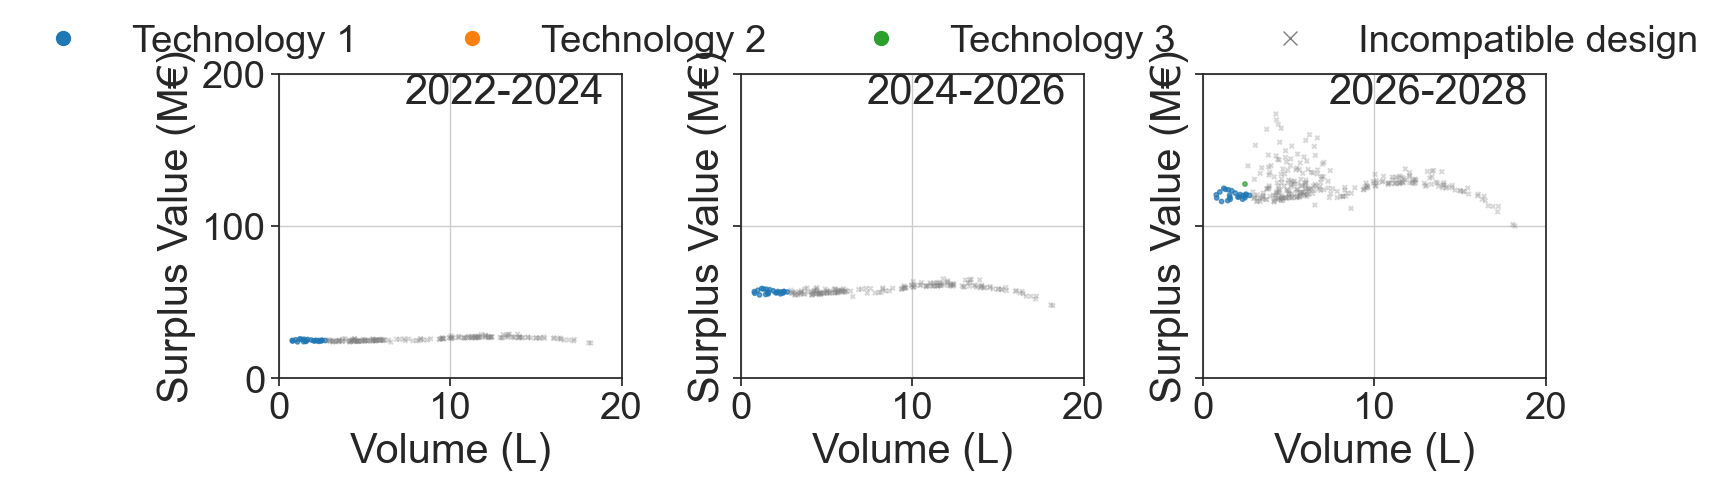

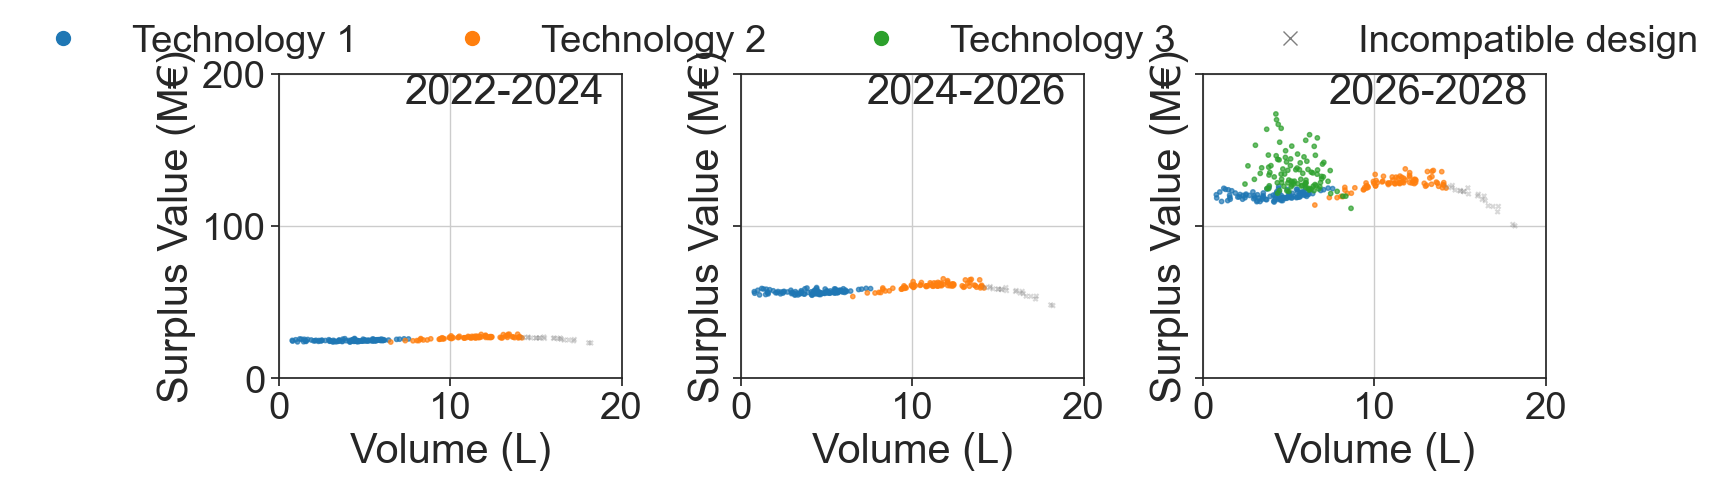

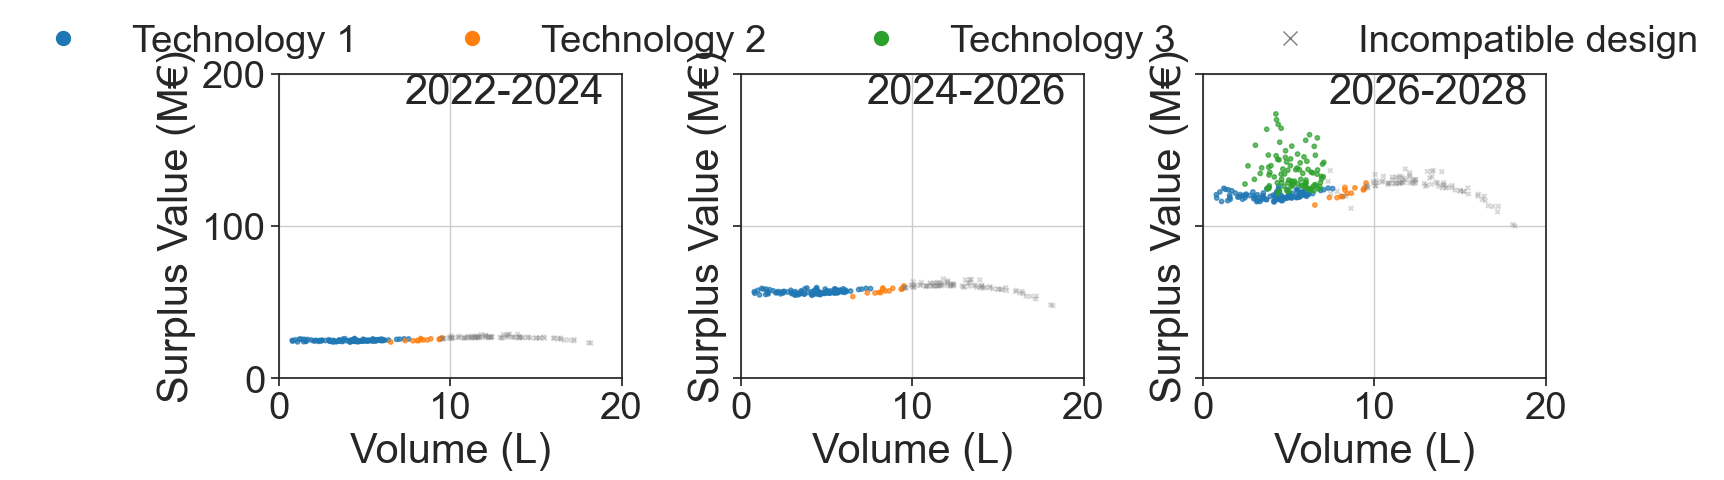

In [11]:
plot_figure_SV_V(designs)

C:\Users\inigoa\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\inigoa\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\inigoa\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
C:\Users\inigoa\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:848: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
C:\Users\inigoa\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:181: UserWarning: You have mi

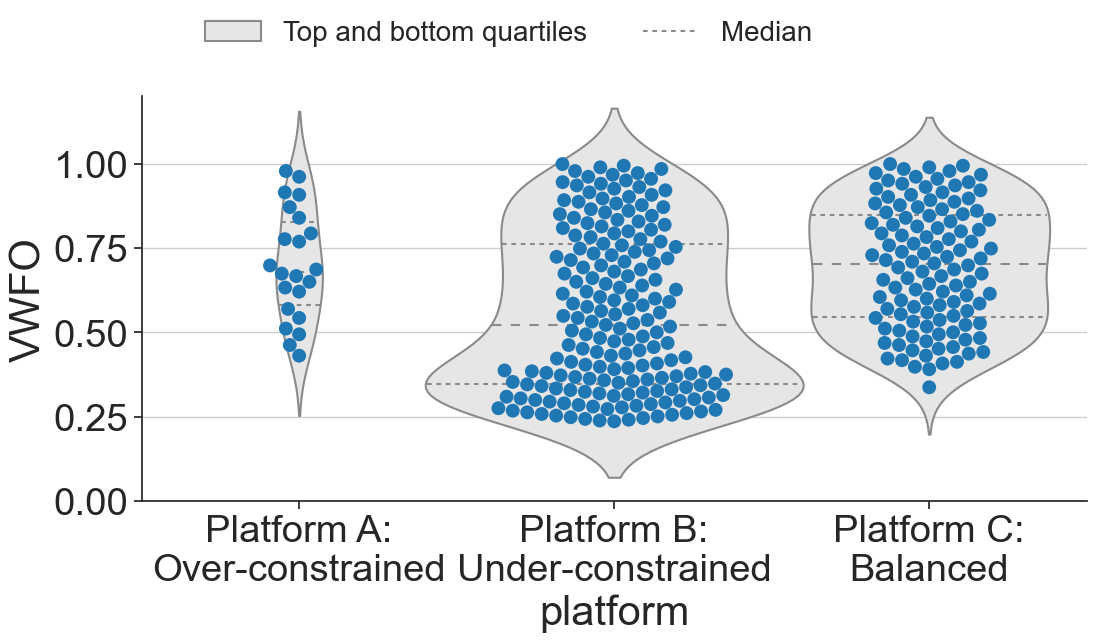

In [12]:
plot_violinplot(df,puntos4)